## Covid Positive X-Ray

------------------

#### Predicting Covid-19 Positive X-Ray images

Data for this analysis comes from Chowdhury et al.'s 2020 study, “Can AI help in screening Viral and COVID-19 pneumonia?”

This dataset includes chest X-ray images of the coronavirus disease (Covid-19), pneumonia, and normal health. 

I will be constructing machine learning models to predict when a chest X-ray image contains Covid-19. Detecting Covid-19 using machine learning techniques is useful because as Chowdhury et al. note, current diagnosis tools for Covid-19 can be expensive and require medical professional. Machine learning models offer a robust automation alternative for detecting Covid-19, and can be useful for quickly and efficiently predicting its presence based off of X-ray images.

--------------------

In [ ]:
# Download and unzip data 
!gdown --id 1xt7g5LkZuX09e1a8rK9sRXIrGFN6rjzl 
!unzip COVID-19_Radiography_Database.zip

In [ ]:
# Colab Setup: 
# note that tabular preprocessors require scikit-learn>=0.24.0
# Newest Tensorflow 2 has some bugs for onnx conversion
!pip install scikit-learn --upgrade 
import os
os.environ['TF_KERAS'] = '1'
% tensorflow_version 1

In [3]:
import sys
import time
import cv2
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import os
import zipfile

from skimage.transform import resize
from sklearn.model_selection import train_test_split

from tensorflow.python.keras.utils import np_utils
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization, GlobalAveragePooling2D
from tensorflow.python.keras.layers.convolutional import Conv2D, MaxPooling2D 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow.keras.applications import VGG19, ResNet50, InceptionV3, InceptionV3, InceptionResNetV2
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras import backend as K

In [72]:
# Extracting all filenames iteratively
base_path = 'COVID-19 Radiography Database'
categories = ['COVID', 'NORMAL', 'Viral Pneumonia']

# load file names to fnames list object
fnames = []
for category in categories:
    image_folder = os.path.join(base_path, category)
    file_names = os.listdir(image_folder)
    full_path = [os.path.join(image_folder, file_name) for file_name in file_names]
    fnames.append(full_path)

print('number of images for each category:', [len(f) for f in fnames])
# print(fnames[0:2]) #examples of file names

number of images for each category: [1200, 1341, 1345]


In [5]:
# Import image, load to array of shape height, width, channels, then min/max transform.
# Write preprocessor that will match up with model's expected input shape.
# Uses opencv for image preprocessing

def preprocessor(data, shape=(192, 192)):
        """
        This function reads in images, resizes them to a fixed shape, and
        min/max transforms them, before converting feature values to float32
        for ONNX.
        
        params:
            data
                list of unprocessed images
                      
        returns:
            X
                numpy array of preprocessed image data
                  
        """
           
        import cv2
        import numpy as np

        "Resize a color image and min/max transform the image"
        img = cv2.imread(data) # Read in image from filepath.
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # cv2 reads in images in order of blue green and red, we reverse the order for ML.
        #grayscale image?  Use im_gray = cv2.imread('gray_image.png', cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, shape) # Change height and width of image.
        img = img / 255.0 # Min-max transform.  

        # Resize the images.
        X = np.array(img)
        #X = np.expand_dims(X, axis=0) # Expand dims to add "1" to object shape [1, h, w, channels] if needed.
        X = np.array(X, dtype=np.float32) # Final shape for onnx runtime.
        return X

preprocessor('COVID-19 Radiography Database/COVID/COVID (1).png').shape

(192, 192, 3)

In [6]:
#Import image files iteratively and preprocess them into array of correctly structured data

# Create list of file paths
image_filepaths=fnames[0]+fnames[1]+fnames[2]

preprocessed_image_data=list(map(preprocessor,image_filepaths ))

# Object needs to be an array rather than a list for Keras (map returns to list object)
X= np.array(preprocessed_image_data) # Assigning to X to highlight that this represents feature input data for our model

In [7]:
len(image_filepaths)

3886

In [8]:
print(len(X) ) #same number of elements as filenames
print(X.shape ) #dimensions now 192,192,3 for all images
print(X.min() ) #min value of every image is zero
print(X.max() ) #max value of every image is one


3886
(3886, 192, 192, 3)
0.0
1.0


In [9]:
# Create y data made up of correctly ordered labels from file folders
from itertools import repeat

print('number of images for each category:', [len(f) for f in fnames])
covid=list(repeat("COVID", 1200))
normal=list(repeat("NORMAL", 1341))
pneumonia=list(repeat("PNEUMONIA", 1345))

#combine into single list of y labels
y_labels = covid+normal+pneumonia

#check length, same as X above
print(len(y_labels) )

import pandas as pd
y=pd.get_dummies(y_labels)

display(y)

number of images for each category: [1200, 1341, 1345]
3886


,COVID,NORMAL,PNEUMONIA
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0
...,...,...,...
3881,0,0,1
3882,0,0,1
3883,0,0,1
3884,0,0,1


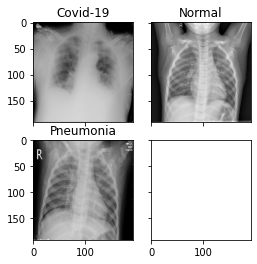

In [52]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
import random

im1 =preprocessor('COVID-19 Radiography Database/COVID/COVID (1).png')
im2 =preprocessor('COVID-19 Radiography Database/NORMAL/NORMAL (1).png')
im3 =preprocessor('COVID-19 Radiography Database/Viral Pneumonia/Viral Pneumonia (1).png')

fig = plt.figure(figsize=(4., 4.))
grid = ImageGrid(fig, 111,  
                 nrows_ncols=(2, 2),  
                 axes_pad=0.25,  
                 )

for ax, im, title in zip(grid, [im1, im2, im3], ["Covid-19", "Normal", "Pneumonia"]):
    ax.set_title(title, fontdict=None, loc='center', color = "k")
    ax.imshow(im)
plt.show()

In [11]:
# ======Train test split resized images====== 
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.20, random_state = 1987)

y_test.sum()

COVID        240
NORMAL       269
PNEUMONIA    269
dtype: int64

In [15]:
# performance metrics
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
import pandas as pd
from math import sqrt

def predict_classes(x): # adjusted from keras github code
  proba=x
  if proba.shape[-1] > 1:
      return proba.argmax(axis=-1)
  else:
      return (proba > 0.5).astype("int32")

def model_eval_metrics(y_true, y_pred,classification="TRUE"):
     if classification=="TRUE":
        accuracy_eval = accuracy_score(y_true, y_pred)
        f1_score_eval = f1_score(y_true, y_pred,average="macro",zero_division=0)
        precision_eval = precision_score(y_true, y_pred,average="macro",zero_division=0)
        recall_eval = recall_score(y_true, y_pred,average="macro",zero_division=0)
        mse_eval = 0
        rmse_eval = 0
        mae_eval = 0
        r2_eval = 0
        metricdata = {'accuracy': [accuracy_eval], 'f1_score': [f1_score_eval], 'precision': [precision_eval], 'recall': [recall_eval], 'mse': [mse_eval], 'rmse': [rmse_eval], 'mae': [mae_eval], 'r2': [r2_eval]}
        finalmetricdata = pd.DataFrame.from_dict(metricdata)
     else:
        accuracy_eval = 0
        f1_score_eval = 0
        precision_eval = 0
        recall_eval = 0
        mse_eval = mean_squared_error(y_true, y_pred)
        rmse_eval = sqrt(mean_squared_error(y_true, y_pred))
        mae_eval = mean_absolute_error(y_true, y_pred)
        r2_eval = r2_score(y_true, y_pred)
        metricdata = {'accuracy': [accuracy_eval], 'f1_score': [f1_score_eval], 'precision': [precision_eval], 'recall': [recall_eval], 'mse': [mse_eval], 'rmse': [rmse_eval], 'mae': [mae_eval], 'r2': [r2_eval]}
        finalmetricdata = pd.DataFrame.from_dict(metricdata)
     return finalmetricdata

### Sequential model

In [16]:
with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  model = tf.keras.Sequential([
    # input: images of size Sample size, height, width, channels 1x192x192x3 pixels (the three stands for RGB channels)    
    tf.keras.layers.Conv2D(kernel_size=3, filters=64, padding='same', activation='relu', input_shape=(192, 192, 3)),
    tf.keras.layers.Conv2D(kernel_size=1, filters=64, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=64, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=64, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=16, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=8, padding='same', activation='relu'),
    tf.keras.layers.Flatten(),
    # classifying into 3 categories
    tf.keras.layers.Dense(3, activation='softmax')
  ])

  from tensorflow.python.keras.callbacks import ReduceLROnPlateau
  red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1) 

  model.compile(
    optimizer="adam", # to use callback set lr arg such as Adam(lr=0.001) instead
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
  
  # Fitting the CNN to the Training set
  model.fit(X_train, y_train, 
                    epochs = 20, verbose=1,callbacks=[red_lr]) #for callback that automatically adjusts lr

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Train on 3108 samples
Epoch 1/20
3108/3108 [==============================] - 16s 5ms/sample - loss: 0.6324 - acc: 0.6937
Epoch 2/20
3108/3108 [==============================] - 7s 2ms/sample - loss: 0.2562 - acc: 0.9086
Epoch 3/20
3108/3108 [==============================] - 7s 2ms/sample - loss: 0.2106 - acc: 0.9295
Epoch 4/20
3108/3108 [==============================] - 7s 2ms/sample - loss: 0.1607 - acc: 0.9450
Epoch 5/20
3108/3108 [==============================] - 8s 2ms/sample - loss: 0.1427 - acc: 0.9508
Epoch 6/20
3108/3108 [==============================] - 8s 2ms/sample - loss: 0.1125 - acc: 0.9620
Epoch 7/20
3108/3108 [==============================] - 8s 2ms/sample - loss: 0.1157 - acc: 0.9611
Epoch 8/20
3108/3108 [==============================] - 8s 2ms/sample - loss: 0.1069 - acc: 0.9630
Epoch 9/20
3108/3108 [==============================] - 8s 2ms/sample - loss: 0.0736 - acc: 0.9746
Epoch

In [ ]:
print(predict_classes(model.predict(X_test)))
prediction_index=predict_classes(model.predict(X_test))
labels=pd.get_dummies(y_train).columns
predicted_labels=list(map(lambda x: labels[x], prediction_index))
print(predicted_labels)

In [18]:
# y_test is one hot encoded so we need to extract labels before runing model_eval_metrics()
y_test_labels=y_test.idxmax(axis=1) #extract labels from one hot encoded y_test object

y_test_labels=list(y_test.idxmax(axis=1)) #returns a pandas series of predicted labels

In [19]:
model_eval_metrics( y_test_labels,predicted_labels,classification="TRUE")

,accuracy,f1_score,precision,recall,mse,rmse,mae,r2
0,0.96401,0.964414,0.964441,0.964405,0,0,0,0


### Squeezenet model

In [27]:
l = tf.keras.layers # syntax shortcut

# Create function to define fire modules
def fire(x, squeeze, expand):
  y = l.Conv2D(filters=squeeze, kernel_size=1, padding='same', activation='relu')(x) 
  y1 = l.Conv2D(filters=expand//2, kernel_size=1, padding='same', activation='relu')(y) # note: //2 takes input value and divides by 2, so we reach the dimensions requested with stacking later.
  y3 = l.Conv2D(filters=expand//2, kernel_size=3, padding='same', activation='relu')(y)
  return tf.keras.layers.concatenate([y1, y3])

# this is to make it behave similarly to other Keras layers
def fire_module(squeeze, expand):
  return lambda x: fire(x, squeeze, expand)

with tf.device('/device:GPU:0'): 
            x = tf.keras.layers.Input(shape=[192,192, 3]) # input is 192x192 pixels RGB
            # x (input layer) stacked on top of the convolutional layer
            y = tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu')(x)
            y = fire_module(34, 68)(y)
            y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
            y = fire_module(34, 68)(y)
            y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
            y = fire_module(34, 68)(y)
            y = tf.keras.layers.GlobalAveragePooling2D()(y) # Takes average of h x w for each channel and returns 1 scalar value per channel
            y = tf.keras.layers.Dense(3, activation='softmax')(y) # Parameters for final layer from GAP = number of channels in previous layer plus number of dense nodes in output layer times number of dense nodes

            model = tf.keras.Model(x, y)
        
            model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc', 'AUC']) 
        
            model.fit(X_train, y_train, 
                    epochs = 25, verbose=1)

Train on 3108 samples
Epoch 1/25
3108/3108 [==============================] - 17s 6ms/sample - loss: 1.0357 - acc: 0.4044 - auc: 0.6462
Epoch 2/25
3108/3108 [==============================] - 15s 5ms/sample - loss: 0.8771 - acc: 0.5730 - auc: 0.7912
Epoch 3/25
3108/3108 [==============================] - 15s 5ms/sample - loss: 0.7143 - acc: 0.6760 - auc: 0.8660
Epoch 4/25
3108/3108 [==============================] - 15s 5ms/sample - loss: 0.6127 - acc: 0.7233 - auc: 0.8978
Epoch 5/25
3108/3108 [==============================] - 14s 5ms/sample - loss: 0.5597 - acc: 0.7632 - auc: 0.9154
Epoch 6/25
3108/3108 [==============================] - 14s 5ms/sample - loss: 0.5034 - acc: 0.8053 - auc: 0.9326
Epoch 7/25
3108/3108 [==============================] - 14s 5ms/sample - loss: 0.4523 - acc: 0.8285 - auc: 0.9445
Epoch 8/25
3108/3108 [==============================] - 15s 5ms/sample - loss: 0.3885 - acc: 0.8520 - auc: 0.9579
Epoch 9/25
3108/3108 [==============================] - 15s 5ms/sa

In [ ]:
print(predict_classes(model.predict(X_test)))
prediction_index=predict_classes(model.predict(X_test))
labels=pd.get_dummies(y_train).columns
predicted_labels=list(map(lambda x: labels[x], prediction_index))
print(predicted_labels)

In [29]:
# y_test is one hot encoded so we need to extract labels before runing model_eval_metrics()
y_test_labels=y_test.idxmax(axis=1) #extract labels from one hot encoded y_test object

y_test_labels=list(y_test.idxmax(axis=1)) #returns a pandas series of predicted labels

In [30]:
model_eval_metrics( y_test_labels,predicted_labels,classification="TRUE")

,accuracy,f1_score,precision,recall,mse,rmse,mae,r2
0,0.929306,0.92975,0.929492,0.931247,0,0,0,0


------------------------

### Squeezenet model with batch normalization

In [66]:
with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  def fire(x, squeeze, expand):
    y  = tf.keras.layers.Conv2D(filters=squeeze, kernel_size=1, activation='relu', padding='same')(x)
    y = tf.keras.layers.BatchNormalization()(y)
    y1 = tf.keras.layers.Conv2D(filters=expand//2, kernel_size=1, activation='relu', padding='same')(y)
    y1 = tf.keras.layers.BatchNormalization()(y1)
    y3 = tf.keras.layers.Conv2D(filters=expand//2, kernel_size=5, activation='relu', padding='same')(y)
    y3 = tf.keras.layers.BatchNormalization()(y3)
    return tf.keras.layers.concatenate([y1, y3])

  def fire_module(squeeze, expand):
    return lambda x: fire(x, squeeze, expand)

  x = tf.keras.layers.Input(shape=[192,192, 3]) # input is 192x192 pixels RGB

  y = tf.keras.layers.Conv2D(kernel_size=3, filters=96, padding='same',  activation='relu')(x)
  y = tf.keras.layers.BatchNormalization()(y)
  y = fire_module(24, 48)(y)
  y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
  y = fire_module(48, 96)(y)
  y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
  y = fire_module(64, 128)(y)
  y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
  y = fire_module(72, 256)(y)
  y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
  y = fire_module(96, 512)(y)
  y = tf.keras.layers.GlobalAveragePooling2D()(y) # Takes average of h x w for each channel and returns 1 scalar value per channel
  y = tf.keras.layers.Dense(3, activation='softmax')(y)

  model = tf.keras.Model(x, y)

  model.compile(
    optimizer='adam',
    loss= 'categorical_crossentropy',
    metrics=['accuracy','AUC'])

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc','AUC']) 

  model.fit(X_train, y_train,
          epochs = 20, verbose=1)

Train on 3108 samples
Epoch 1/20
3108/3108 [==============================] - 29s 9ms/sample - loss: 0.3632 - acc: 0.8793 - auc_46: 0.9641
Epoch 2/20
3108/3108 [==============================] - 26s 8ms/sample - loss: 0.1646 - acc: 0.9379 - auc_46: 0.9918
Epoch 3/20
3108/3108 [==============================] - 26s 8ms/sample - loss: 0.1180 - acc: 0.9595 - auc_46: 0.9952
Epoch 4/20
3108/3108 [==============================] - 26s 8ms/sample - loss: 0.0932 - acc: 0.9636 - auc_46: 0.9972
Epoch 5/20
3108/3108 [==============================] - 26s 8ms/sample - loss: 0.1165 - acc: 0.9585 - auc_46: 0.9956
Epoch 6/20
3108/3108 [==============================] - 26s 8ms/sample - loss: 0.1126 - acc: 0.9601 - auc_46: 0.9957
Epoch 7/20
3108/3108 [==============================] - 26s 8ms/sample - loss: 0.0688 - acc: 0.9759 - auc_46: 0.9986
Epoch 8/20
3108/3108 [==============================] - 26s 8ms/sample - loss: 0.0720 - acc: 0.9743 - auc_46: 0.9984
Epoch 9/20
3108/3108 [====================

In [ ]:
print(predict_classes(model.predict(X_test)))
prediction_index=predict_classes(model.predict(X_test))
labels=pd.get_dummies(y_train).columns
predicted_labels=list(map(lambda x: labels[x], prediction_index))
print(predicted_labels)

In [68]:
# y_test is one hot encoded so we need to extract labels before runing model_eval_metrics()
y_test_labels=y_test.idxmax(axis=1) #extract labels from one hot encoded y_test object

y_test_labels=list(y_test.idxmax(axis=1)) #returns a pandas series of predicted labels

In [69]:
model_eval_metrics( y_test_labels,predicted_labels,classification="TRUE")

,accuracy,f1_score,precision,recall,mse,rmse,mae,r2
0,0.780206,0.762473,0.861516,0.787954,0,0,0,0


The squeezenet model does not perform as well with batch normalization.

-------------------

### VGG16 model

In [31]:
IMG_SHAPE = (192, 192, 3)

base_model = InceptionV3(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')
# base_model.summary() # Notice unfrozen number of trainable parameters

# Create new classifier layers (and plug into output of last layer from above model using "model.layers[-1].output")
flat1 = Flatten()(base_model.layers[-1].output)
class1 = Dense(1024, activation='relu')(flat1)
output = Dense(3, activation='softmax')(class1)
# define new model
model = Model(inputs=base_model.inputs, outputs=output) #base_model.inputs imports the vgg16 model defined in base_model
  
# Fit VGG16 model with frozen imagent weights and new input/output layer shapes (outputs have trainable parameters)

with tf.device('/device:GPU:0'): 
  from tensorflow.python.keras.callbacks import ReduceLROnPlateau
  from tensorflow.python.keras.callbacks import ModelCheckpoint
  
  mc = ModelCheckpoint('best_model.h5', monitor='AUC',mode='max', verbose=1, save_best_only=True)
  red_lr= ReduceLROnPlateau(monitor='AUC',patience=2,verbose=1,factor=0.5, min_lr=0.001) # dividing lr by 2 when val_accuracy fails to improve after 2 epochs

  model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['acc','AUC']) 

  model.fit(X_train, y_train,batch_size=1,
          epochs = 25, verbose=1,callbacks=[mc,red_lr])

87916544/87910968 [==============================] - 1s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 192, 192, 3) 0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 95, 95, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 95, 95, 32)   96          conv2d_20[0][0]                  
__________________________________________________________________________________________________
activation (Activation)         (None, 95, 95, 32)   0           batch_normalization[0][0]        
______________________

In [ ]:
print(predict_classes(model.predict(X_test)))
prediction_index=predict_classes(model.predict(X_test))
labels=pd.get_dummies(y_train).columns
predicted_labels=list(map(lambda x: labels[x], prediction_index))
print(predicted_labels)

In [33]:
# y_test is one hot encoded so we need to extract labels before runing model_eval_metrics()
y_test_labels=y_test.idxmax(axis=1) #extract labels from one hot encoded y_test object

y_test_labels=list(y_test.idxmax(axis=1)) #returns a pandas series of predicted labels

In [34]:
model_eval_metrics( y_test_labels,predicted_labels,classification="TRUE")

,accuracy,f1_score,precision,recall,mse,rmse,mae,r2
0,0.938303,0.938173,0.938004,0.939173,0,0,0,0


### ResNet model

In [39]:
base_model = ResNet50(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')
base_model.trainable = False
# base_model.summary() # Notice unfrozen number of trainable parameters

# Fine-tune everything up to this layer onwards
freeze_layers_after=30

# Freeze all the layers after the `freeze_layers_after` layer
for layer in base_model.layers[freeze_layers_after:]:
  layer.trainable =  False

with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  mc = ModelCheckpoint('best_model.h5', monitor='AUC',mode='max', verbose=1, save_best_only=True) # evaluating val_acc maximization
  red_lr= ReduceLROnPlateau(monitor='AUC',patience=2,verbose=1,factor=0.5, min_lr=0.001) # dividing lr by 2 when val_accuracy fails to improve after 2 epochs

  model.compile(
    optimizer='adam',
    loss= 'categorical_crossentropy',
    metrics=['accuracy', 'AUC'])

  model.fit(X_train, y_train,
          epochs = 25, verbose=1,callbacks=[mc,red_lr])

Train on 3108 samples
Epoch 1/25
3108/3108 [==============================] - 29s 9ms/sample - loss: 0.3458 - acc: 0.9228 - auc_6: 0.9812
Epoch 2/25
3108/3108 [==============================] - 20s 7ms/sample - loss: 0.1405 - acc: 0.9546 - auc_6: 0.9936
Epoch 3/25
3108/3108 [==============================] - 20s 7ms/sample - loss: 0.1268 - acc: 0.9617 - auc_6: 0.9936
Epoch 4/25
3108/3108 [==============================] - 20s 6ms/sample - loss: 0.0625 - acc: 0.9788 - auc_6: 0.9983
Epoch 5/25
3108/3108 [==============================] - 20s 6ms/sample - loss: 0.0806 - acc: 0.9733 - auc_6: 0.9976
Epoch 6/25
3108/3108 [==============================] - 20s 6ms/sample - loss: 1.9503 - acc: 0.6947 - auc_6: 0.8718
Epoch 7/25
3108/3108 [==============================] - 20s 6ms/sample - loss: 0.6710 - acc: 0.6689 - auc_6: 0.8673
Epoch 8/25
3108/3108 [==============================] - 20s 6ms/sample - loss: 0.4519 - acc: 0.8404 - auc_6: 0.9456
Epoch 9/25
3108/3108 [============================

In [ ]:
print(predict_classes(model.predict(X_test)))
prediction_index=predict_classes(model.predict(X_test))
labels=pd.get_dummies(y_train).columns
predicted_labels=list(map(lambda x: labels[x], prediction_index))
print(predicted_labels)

In [41]:
# y_test is one hot encoded so we need to extract labels before runing model_eval_metrics()
y_test_labels=y_test.idxmax(axis=1) #extract labels from one hot encoded y_test object

y_test_labels=list(y_test.idxmax(axis=1)) #returns a pandas series of predicted labels

In [42]:
model_eval_metrics( y_test_labels,predicted_labels,classification="TRUE")

,accuracy,f1_score,precision,recall,mse,rmse,mae,r2
0,0.966581,0.966779,0.966894,0.966734,0,0,0,0


### Evaluation

In this report, I trained several deep learning models to classify X-ray images as either Covid-19 positive, Pneumonia, or Normal.

The best performing models are the **Sequential** neural network model and **ResNet**. Both received 96% on all metric fields, including accuracy, f1-score, precision, and recall.

Both models trained using callback to automatically adjust learning rate. ResNet used layer freezing set to 30 to accelerate to model training process. ResNet used epochs set to 25 and the Sequential model set to 20. The Sequential model used relu activation for its layers and various filter sizes, ranging from 8 to 64.


-----------------

### References

M.E.H. Chowdhury, T. Rahman, A. Khandakar, R. Mazhar, M.A. Kadir, Z.B. Mahbub, K.R. Islam, M.S. Khan, A. Iqbal, N. Al-Emadi, M.B.I. Reaz, “Can AI help in screening Viral and COVID-19 pneumonia?” arXiv preprint, 29 March 2020, https://arxiv.org/abs/2003.13145

------------------

### Share best models to leaderboard

In [26]:
# test with aimodelshare library
! pip install aimodelshare --upgrade --extra-index-url https://test.pypi.org/simple/ 

In [43]:
import aimodelshare as ai
ai.export_preprocessor(preprocessor,"") #ignore error "can't pickle module objects"

In [44]:
from aimodelshare.aimsonnx import model_to_onnx
# transform sklearn model to ONNX
onnx_model_keras= model_to_onnx(model, framework='keras', 
                                   transfer_learning=True,
                                   deep_learning=True,
                                   task_type='classification')

# Save model to local .onnx file
with open("onnx_model_keras.onnx", "wb") as f:
    f.write(onnx_model_keras.SerializeToString())

The ONNX operator number change on the optimization: 830 -> 225


In [22]:
# Set credentials to submit new model/preprocessor
from google.colab import drive
drive.mount('/content/drive')

from aimodelshare.aws import set_credentials
set_credentials(credential_file="/content/drive/My Drive/Adv. Machine Learning/Code/assignment_2/credentials.txt", type="submit_model", apiurl="https://sxr89y55o4.execute-api.us-east-1.amazonaws.com/prod/m") #Covid image prediction apiURL

Mounted at /content/drive
AI Model Share login credentials set successfully.
AWS credentials set successfully.


In [45]:
import aimodelshare as ai
import os
token=ai.aws.get_aws_token(os.environ.get("username"), os.environ.get("password"))
awscreds=ai.aws.get_aws_client(aws_key=os.environ.get('AWS_ACCESS_KEY_ID'), aws_secret=os.environ.get('AWS_SECRET_ACCESS_KEY'), aws_region=os.environ.get('AWS_REGION'))

In [46]:
# Submit_model() to leaderboard
ai.submit_model("onnx_model_keras.onnx",
                "https://sxr89y55o4.execute-api.us-east-1.amazonaws.com/prod/m",
                token,awscreds,prediction_submission=predicted_labels,
                preprocessor="preprocessor.zip")

'Your model has been submitted as model version 43'

In [ ]:
import pandas
data=ai.get_leaderboard("https://sxr89y55o4.execute-api.us-east-1.amazonaws.com/prod/m",
                token,awscreds,verbose=1)

#get rid of any duplicate model submissions
#data=data.loc[data.iloc[:,0:8].duplicated()==False,:]
data.fillna(0,inplace=True)
data

In [ ]:
ai.stylize_leaderboard(data,category="classification")